## Data Exploration Summary and Conclusions
The dataset has five numerical features, eight nominal features and one ordinal feature. The target is a binary variable that is True if the subject's income is less than or equal to $50k, and False otherwise. Based on the exploratory analysis, the following preprocessing steps are needed before building the model:

1) **Unknown Values** - There are no missing values in the dataset, but three nominal features ('workclass', 'occupation', and 'native-country') have '?' to mark unknown values. Unknown values for 'workclass' and 'occupation' are almost perfectly correlated and seem to signify subjects lacking occupation, which is highly relevant for our prediction task. On the other hand, unknown values for 'native-country' are not correlated with those of the other variables, and may signify data quality issues. Therefore, I will drop rows with unknown 'native-country'.

2) **Education Features** - 'education' and 'education-num' represent similar information, with the former including nominal text categories (e.g. 'Bachelors') and the latter ordinal categories represented as integers, with a higher number representing higher educational achievement. I will therefore drop 'education', since the information it includes is redundant with that in 'education-num' (but not the other way around!).

3) **Superfluous Categories** - The categorical features include many categories that have few data examples and, after one-hot-encoding, would result in a cluttered dataset with many features of very little importance. Therefore, I will merge categories that have similar statistical relationships with the target variable.

4) **Common Procedures** - The data requires scaling (for numerical features) and one-hot-encoding (for nominal features).

The analysis below supports these conclusions and provides further information about the dataset.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go

pd.options.display.float_format = '{:.3f}'.format

In [2]:
df_1 = pd.read_csv("adult.data", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                                             'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                                             'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                                             '<=50K'], skipinitialspace=True)
df_2 = pd.read_csv("adult.test", names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                                             'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                                             'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                                             '<=50K'], skipinitialspace=True, skiprows=1)
df_2['<=50K'] = df_2['<=50K'].str.strip('.')

df_combined = df_1.append(df_2)

df_combined = df_combined.sample(frac=1, random_state=0)

df_train = df_combined.iloc[:int(df_combined.shape[0] * .75)].copy()
df_test = df_combined.iloc[int(df_combined.shape[0] * .75):].copy()
df_train.shape, df_test.shape

((36631, 15), (12211, 15))

In [3]:
from statsmodels.stats.proportion import proportion_confint

def explore_categorical_feature(var, df = df_train, target = '<=50K Numeric', ci_alpha=0.05):
    # This function performs a deeper exploration of the categorical features
    cat_explore = pd.concat([df[var].value_counts(), df[var].value_counts()/df.shape[0], 
                             df.groupby(var)[target].mean()], 
                            axis=1, sort=False, keys=['Count', 'Share', 'Positive Rate'])
    cat_explore.index.name = var    
    cat_explore['ci'] = cat_explore.apply(lambda x: proportion_confint(x['Count'] * x['Positive Rate'], x['Count'],
                                                                   alpha=ci_alpha, method='jeffreys'),  axis = 1)
    cat_explore['Conf Interval Lower'] = cat_explore['ci'].apply(lambda x: x[0])
    cat_explore['Conf Interval Upper'] = cat_explore['ci'].apply(lambda x: x[1])  
    return cat_explore.drop(['ci'], axis=1).sort_values('Count', ascending = False)
# explore_categorical_feature('race')

### Initial Data Exploration

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36631 entries, 5552 to 14177
Data columns (total 15 columns):
age               36631 non-null int64
workclass         36631 non-null object
fnlwgt            36631 non-null int64
education         36631 non-null object
education-num     36631 non-null int64
marital-status    36631 non-null object
occupation        36631 non-null object
relationship      36631 non-null object
race              36631 non-null object
sex               36631 non-null object
capital-gain      36631 non-null int64
capital-loss      36631 non-null int64
hours-per-week    36631 non-null int64
native-country    36631 non-null object
<=50K             36631 non-null object
dtypes: int64(6), object(9)
memory usage: 4.5+ MB


In [5]:
df_train.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,<=50K
5552,41,Private,151856,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K
6653,57,Self-emp-not-inc,87584,Doctorate,16,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,25,United-States,<=50K
11687,31,Local-gov,220669,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,6849,0,40,United-States,<=50K
10283,55,Private,171355,Assoc-voc,11,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,20,United-States,<=50K
26724,59,Self-emp-not-inc,148626,10th,6,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<=50K


In [6]:
target_value_counts = df_train['<=50K'].value_counts()
labels = list(target_value_counts.index)
values = target_value_counts.values

trace = go.Pie(labels=labels, values=values)

py.iplot([trace], filename='<=50K_pie_chart')

In [7]:
df_train['<=50K Numeric'] = df_train['<=50K'].replace({'<=50K':1, '>50K':0}) 

In [8]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,<=50K Numeric
count,36631.000,36631.000,36631.000,36631.000,36631.000,36631.000,36631.000
mean,38.671,189813.810,10.078,1104.701,85.181,40.433,0.760
std,13.709,105882.287,2.581,7576.635,397.339,12.362,0.427
min,17.000,12285.000,1.000,0.000,0.000,1.000,0.000
25%,28.000,117622.500,9.000,0.000,0.000,40.000,1.000
50%,37.000,178312.000,10.000,0.000,0.000,40.000,1.000
75%,48.000,237868.000,12.000,0.000,0.000,45.000,1.000
max,90.000,1490400.000,16.000,99999.000,4356.000,99.000,1.000


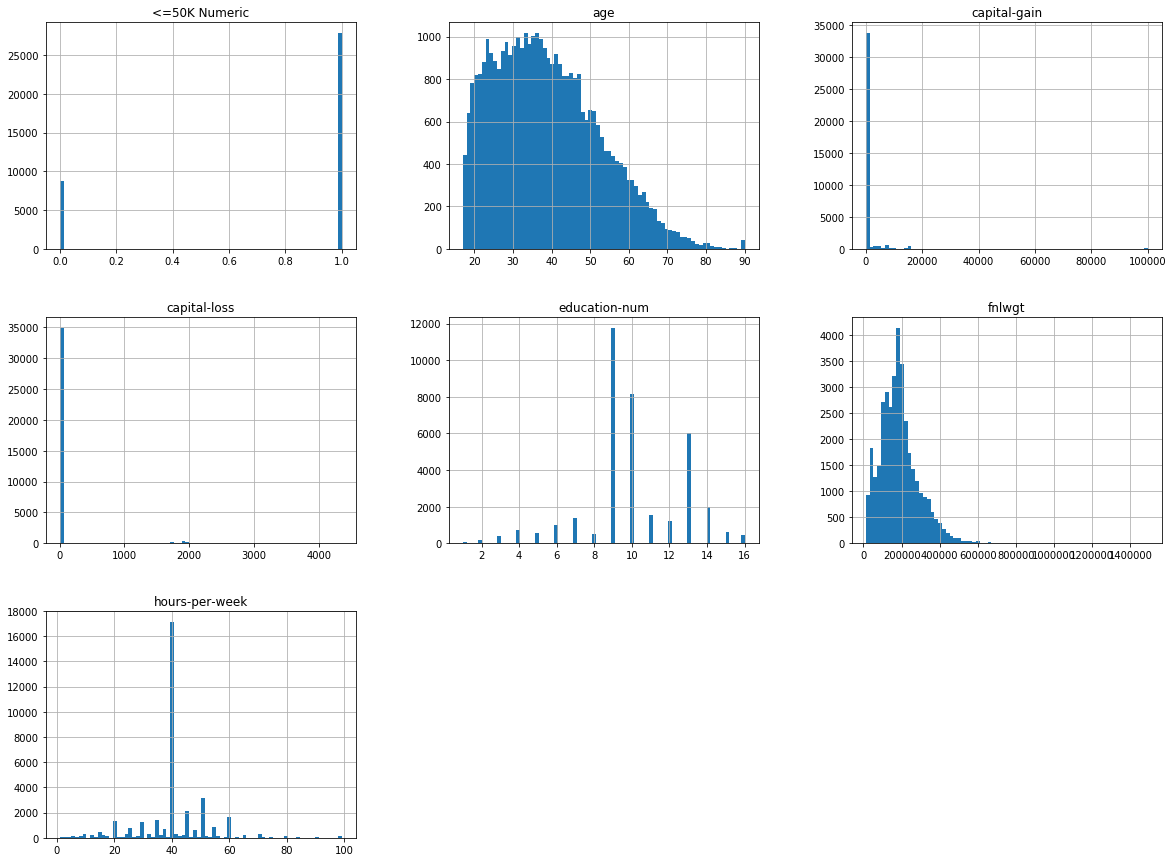

In [9]:
df_train.hist(bins=74, figsize=(20,15))
plt.show()

In [10]:
explore_categorical_feature('workclass')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
workclass,,,,,
Private,25366,0.692,0.781,0.776,0.786
Self-emp-not-inc,2916,0.080,0.726,0.709,0.742
Local-gov,2358,0.064,0.704,0.685,0.722
?,2108,0.058,0.904,0.891,0.916
State-gov,1520,0.041,0.732,0.710,0.754
Self-emp-inc,1268,0.035,0.437,0.410,0.464
Federal-gov,1073,0.029,0.610,0.580,0.638
Without-pay,14,0.000,0.857,0.615,0.969
Never-worked,8,0.000,1.000,0.738,1.000


Without-pay and Never-worked could be combined.

In [11]:
explore_categorical_feature('education')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
education,,,,,
HS-grad,11776,0.321,0.839,0.832,0.845
Some-college,8147,0.222,0.811,0.803,0.820
Bachelors,6043,0.165,0.587,0.574,0.599
Masters,1991,0.054,0.456,0.434,0.477
Assoc-voc,1542,0.042,0.747,0.725,0.768
11th,1371,0.037,0.947,0.935,0.958
Assoc-acdm,1212,0.033,0.738,0.713,0.763
10th,1018,0.028,0.932,0.916,0.946
7th-8th,725,0.020,0.935,0.915,0.951


In [12]:
education_explore = explore_categorical_feature('education-num').sort_index()
education_explore['education'] = df_train.groupby(['education-num'])['education'].max()
education_explore[['education', 'Count', 'Share', 'Positive Rate', 'Conf Interval Lower', 'Conf Interval Upper']]

,education,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
education-num,,,,,,
1,Preschool,65,0.002,0.985,0.930,0.998
2,1st-4th,196,0.005,0.964,0.931,0.984
3,5th-6th,390,0.011,0.944,0.917,0.963
4,7th-8th,725,0.020,0.935,0.915,0.951
5,9th,568,0.016,0.951,0.931,0.966
6,10th,1018,0.028,0.932,0.916,0.946
7,11th,1371,0.037,0.947,0.935,0.958
8,12th,510,0.014,0.927,0.902,0.948
9,HS-grad,11776,0.321,0.839,0.832,0.845


In [13]:
explore_categorical_feature('marital-status')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
marital-status,,,,,
Married-civ-spouse,16843,0.460,0.553,0.545,0.560
Never-married,12074,0.330,0.955,0.951,0.958
Divorced,4960,0.135,0.899,0.890,0.907
Separated,1135,0.031,0.935,0.919,0.948
Widowed,1117,0.030,0.912,0.895,0.928
Married-spouse-absent,470,0.013,0.904,0.875,0.928
Married-AF-spouse,32,0.001,0.625,0.452,0.776


In [14]:
explore_categorical_feature('occupation')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
occupation,,,,,
Prof-specialty,4674,0.128,0.551,0.537,0.565
Craft-repair,4632,0.126,0.768,0.756,0.780
Exec-managerial,4561,0.125,0.524,0.510,0.539
Adm-clerical,4177,0.114,0.863,0.852,0.873
Sales,4116,0.112,0.732,0.719,0.746
Other-service,3625,0.099,0.957,0.950,0.963
Machine-op-inspct,2255,0.062,0.879,0.865,0.892
?,2116,0.058,0.904,0.891,0.916
Transport-moving,1771,0.048,0.791,0.772,0.810


In [15]:
explore_categorical_feature('relationship')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
relationship,,,,,
Husband,14841,0.405,0.551,0.543,0.559
Not-in-family,9479,0.259,0.898,0.892,0.904
Own-child,5639,0.154,0.984,0.981,0.987
Unmarried,3777,0.103,0.941,0.933,0.948
Wife,1761,0.048,0.528,0.505,0.551
Other-relative,1134,0.031,0.966,0.955,0.976


In [16]:
explore_categorical_feature('race')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
race,,,,,
White,31323,0.855,0.745,0.740,0.750
Black,3496,0.095,0.875,0.864,0.886
Asian-Pac-Islander,1152,0.031,0.730,0.704,0.755
Amer-Indian-Eskimo,354,0.010,0.895,0.860,0.924
Other,306,0.008,0.882,0.843,0.915


In [17]:
explore_categorical_feature('sex')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
sex,,,,,
Male,24569,0.671,0.696,0.690,0.701
Female,12062,0.329,0.890,0.884,0.895


In [18]:
explore_categorical_feature('native-country')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
native-country,,,,,
United-States,32808,0.896,0.756,0.751,0.760
Mexico,750,0.020,0.945,0.927,0.960
?,648,0.018,0.721,0.685,0.754
Philippines,230,0.006,0.696,0.634,0.752
Germany,169,0.005,0.710,0.639,0.774
Puerto-Rico,144,0.004,0.882,0.822,0.927
Canada,141,0.004,0.645,0.564,0.721
India,113,0.003,0.637,0.546,0.721
El-Salvador,111,0.003,0.928,0.869,0.965


In [19]:
explore_categorical_feature('<=50K')

,Count,Share,Positive Rate,Conf Interval Lower,Conf Interval Upper
<=50K,,,,,
<=50K,27824,0.760,1,1.000,1.000
>50K,8807,0.240,0,0.000,0.000


In [20]:
corr = df_train.corr()
corr.style.background_gradient().set_precision(2)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,<=50K Numeric
age,1,-0.078,0.031,0.079,0.055,0.068,-0.23
fnlwgt,-0.078,1,-0.034,-0.0012,-0.0019,-0.009,0.0081
education-num,0.031,-0.034,1,0.13,0.084,0.15,-0.33
capital-gain,0.079,-0.0012,0.13,1,-0.031,0.084,-0.23
capital-loss,0.055,-0.0019,0.084,-0.031,1,0.053,-0.15
hours-per-week,0.068,-0.009,0.15,0.084,0.053,1,-0.23
<=50K Numeric,-0.23,0.0081,-0.33,-0.23,-0.15,-0.23,1


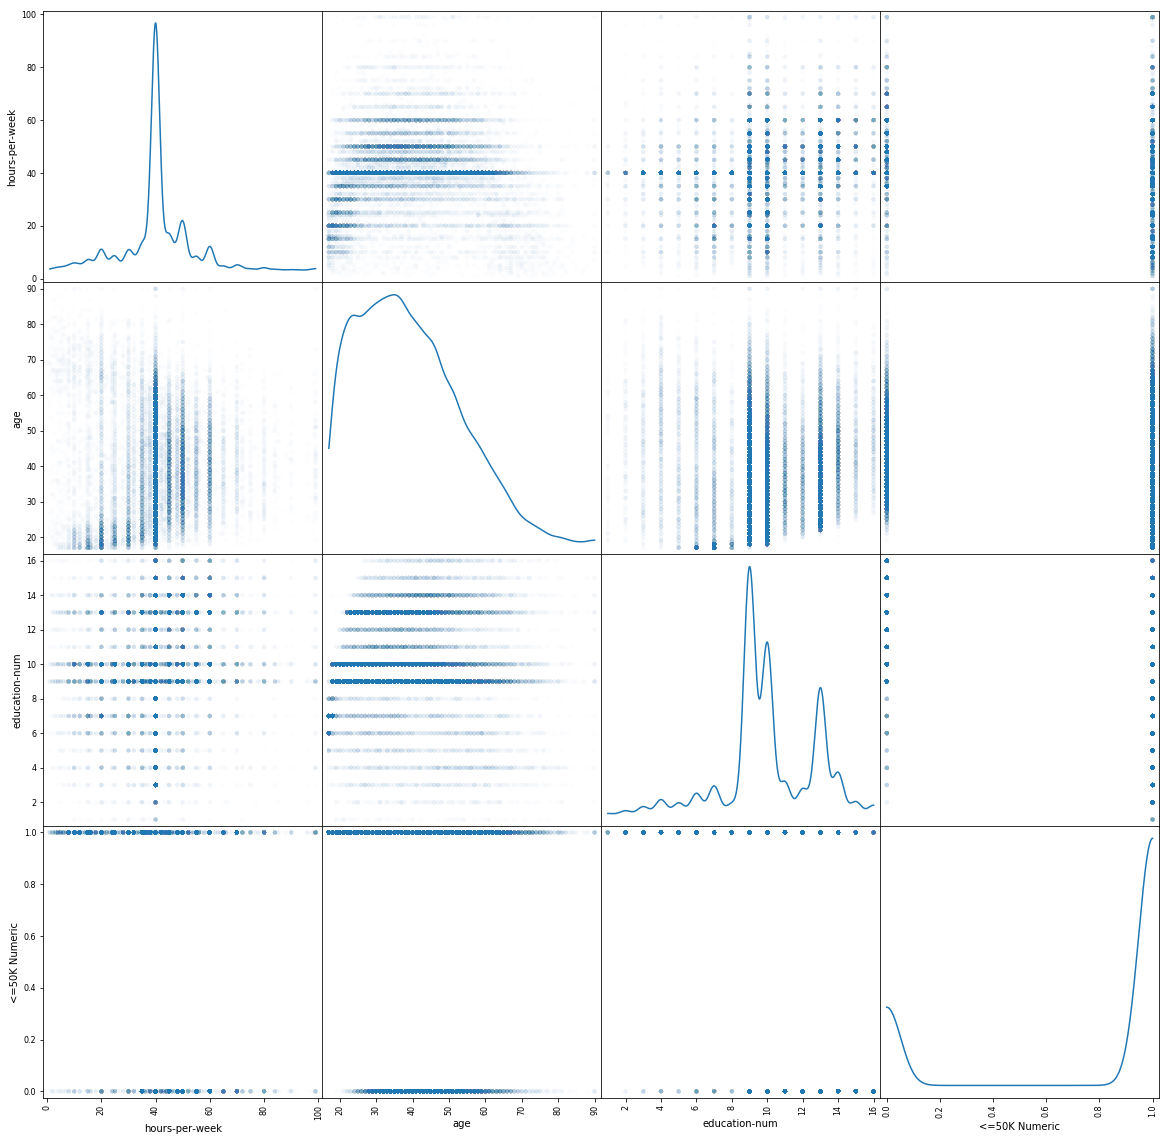

In [21]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(df_train[['hours-per-week', 'age', 'education-num', '<=50K Numeric']], 
                   alpha = 0.01, figsize = (20, 20), diagonal = 'kde', s = 80, linewidth = 3)

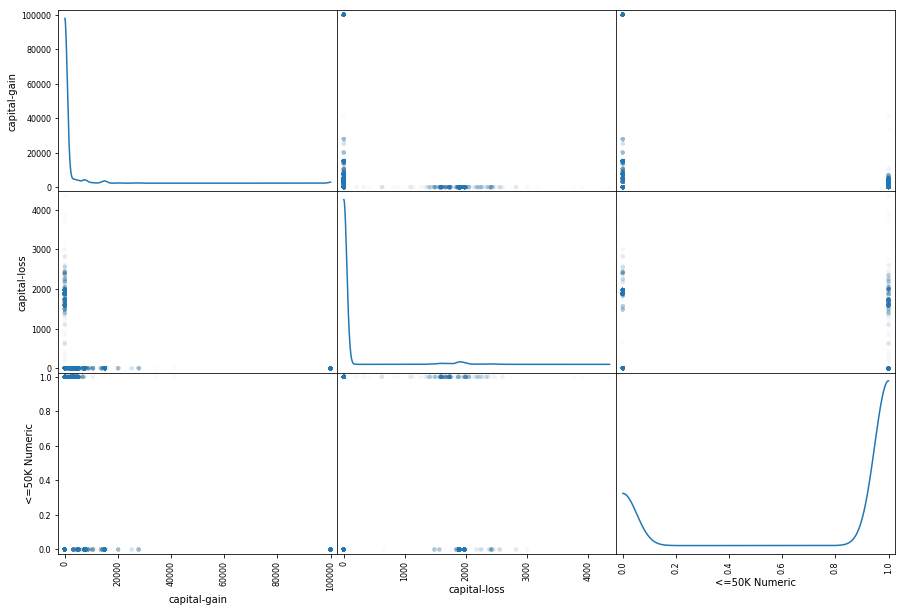

In [22]:
_ = scatter_matrix(df_train[['capital-gain', 'capital-loss', '<=50K Numeric']], 
                   alpha = 0.01, figsize = (15, 10), diagonal = 'kde', s = 80, linewidth = 3)

In [25]:
# Check correlation between unknown values
df_train['unknwon workclass'] = df_train['workclass'] == '?'
df_train['unknwon occupation'] = df_train['occupation'] == '?'
df_train['unknwon native-country'] = df_train['native-country'] == '?'
corr = df_train[['unknwon workclass', 'unknwon occupation', 'unknwon native-country']].corr()
corr.style.background_gradient().set_precision(2)

,unknwon workclass,unknwon occupation,unknwon native-country
unknwon workclass,1,1,-0.00026
unknwon occupation,1,1,-0.00038
unknwon native-country,-0.00026,-0.00038,1
